In [ ]:
ANALISIS EXPLORATORIO DE DATOS

In [26]:
#Importe de librerías a usar
import pandas as pd
import csv
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Leo los archivos
df_user_new = pd.read_csv("df_user_desanidada.csv")
df_item = pd.read_parquet("df_items_sample.parquet")
df_games = pd.read_csv("df_steam_games.csv")

In [18]:
#Los 5 juegos más recomendados
#Del archivo df_user_new se filtran los regoistros con recommend = 1 (True)
df_user_true = df_user_new[df_user_new['recommend'] == 1]
#Se cuenta la totalidad de recomendaciones por item
recommend_by_item = df_user_true.groupby('item_id')['recommend'].count().reset_index()
#Ordenamos descendentemente por recommend_by_item
recommend_by_item = recommend_by_item.sort_values(by='recommend',ascending=False)
#Seleccionamos los primeros 5 juegos
top_5 = recommend_by_item.head(5)
#Cruzamos contra df_games para obtener los nombres de los item
top_5 = pd.merge(top_5, df_games[['id', 'app_name']], left_on='item_id', right_on= 'id', how = 'left')

print(top_5)

   item_id  recommend      id                          app_name
0      730       2235   730.0  Counter-Strike: Global Offensive
1      440       1975   440.0                   Team Fortress 2
2      570        863     NaN                               NaN
3     4000        731  4000.0                       Garry's Mod
4   218620        427     NaN                               NaN


In [ ]:
Los dos juegos más recomendados, Counter-Strike: Global Offensiv y Team Fortress 2, se destacan por ser juegos de 
disparos en primera persona.

In [21]:
#Los juegos con mayor tiempo jugado
top_playtime = df_item.sort_values(by='playtime_forever', ascending=False).head(10)

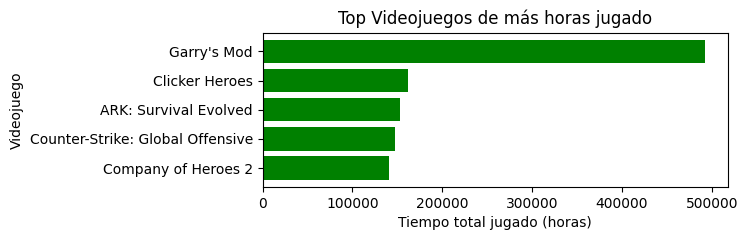

In [24]:
#Se ajusta el tamaño del gráfico
plt.figure(figsize=(6, 2))  

# Graficar los datos
plt.barh(top_playtime['item_name'], top_playtime['playtime_forever'], color='green')
plt.xlabel('Tiempo total jugado (horas)')  # Etiqueta del eje X
plt.ylabel('Videojuego')         # Etiqueta del eje Y
plt.title('Top Videojuegos de más horas jugado')  # Título del gráfico

plt.gca().invert_yaxis()  # Invertir el eje Y para que el juego con más tiempo jugado esté en la parte superior.

# Mostrar el gráfico
plt.show()

Curiosamente, el juego de más horas jugadas es Garry's Mod, un nuego multiplayer en el qiue no hay metas ni objetivos a alcanzar, sino que le ofrece al jugador libertad de manipular objetos y crear personajes a si gusto. Curiosamente, no es el juego más recomendado, aunque está en el top 5 de los más recomendados.

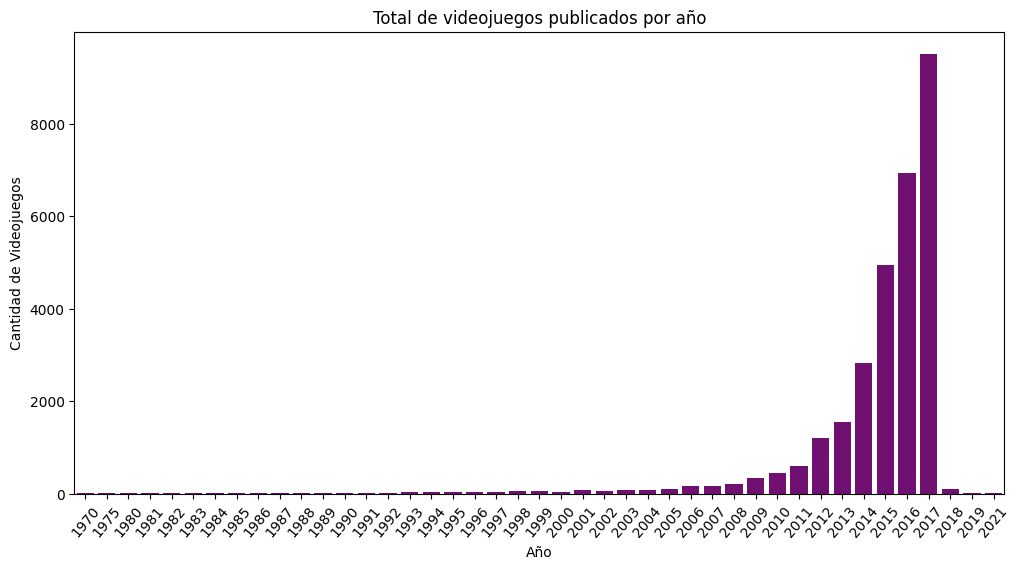

In [27]:
#Cantidad de videojuegos publicados por año
games_for_year = df_games['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=games_for_year.index, y=games_for_year.values, color='purple')
plt.xticks(rotation=50)

plt.xlabel('Año')
plt.ylabel('Cantidad de Videojuegos')
plt.title('Total de videojuegos publicados por año')

plt.show()

NO soy experto en videojuegos, pero la gráfica me permite hacerme a la idea que los juegos publicados entre 2015 y 2017 son muy apetecidos, o pueda ser que generan "apego" entre quienes los han jugado, pues alrededor del 70% de los videojuegos que los usuarios tienen están en ese rango de tiempo. Otra teoría pueda ser que el mercado/economía en ese periodo de tiempo pudo ser favorable para las compañías productoras de videojuegos y les permitió lanzar muchos nuevos juegos o nuevas versiones de los ya existentes para ese entonces. 

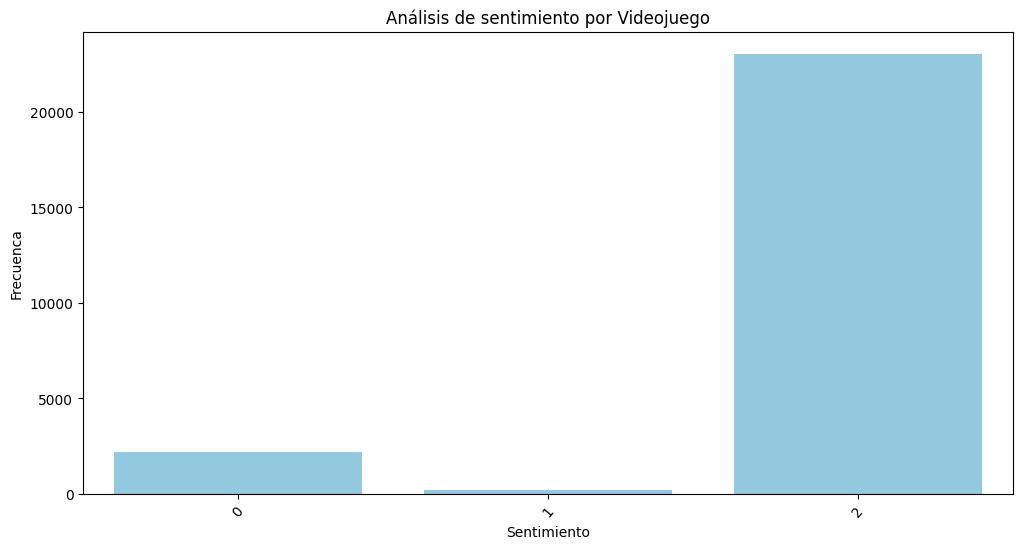

In [34]:
# Analizamos la distribución del análisis de sentimiento

Analisis_sentimiento = df_user_new['sentiment_analysis'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=Analisis_sentimiento.index, y=Analisis_sentimiento.values, color='skyblue')
plt.xticks(rotation=50)

plt.xlabel('Sentimiento')
plt.ylabel('Frecuenca')
plt.title('Análisis de sentimiento por Videojuego')

plt.show()

La gráfica muestra que las sensaciones que brindan los videojuegos a los gamer es muy positiva, porcentualmente, la respuesta positiva estó por encima del 95% aproximadamente.

CREACION DE LA FUNCION def userdata

In [1]:
#Cargue de las funciones a trabajar
import pandas as pd
from fastapi import FastAPI

In [2]:
#Lectura de los archivos a procesar
df_user= pd.read_csv("df_user_desanidada.csv")
df_games= pd.read_csv("df_steam_games.csv")

In [19]:
def userdata(user_id):
    # Filtra las revisiones del usuario específico
    reviews = df_user[df_user['user_id'] == user_id]
    
    # Filtra los juegos jugados por el usuario
    game_ids = reviews['item_id'].unique()
    steam_games = df_games[df_games['id'].astype(float).isin(game_ids)]
    
    # Calcula la cantidad de dinero gastado por el usuario
    steam_games.loc[:, 'price'] = steam_games['price'].astype(float)
    money_spent = steam_games['price'].sum()
    
    # Calcula el porcentaje de recomendación promedio de los juegos jugados por el usuario
    reviews.loc[:, 'recommend'] = reviews['recommend'].astype(bool)
    recommend_percentage = reviews['recommend'].mean() * 100
    
    # Calcula la cantidad de items que posee el usuario
    num_items = len(game_ids)
    
    # Crear un diccionario con los resultados
    user_data = {
        "money_spent": money_spent,
        "recommend_percentage": recommend_percentage,
        "num_items": num_items
    }
    
    return user_data

In [21]:
# Reemplazar "tu_user_id_aqui" con el ID del usuario que deseas consultar
user_id = "evcentric"

# Llama a la función userdata con el user_id específico
resultado_usuario = userdata(user_id)

# Imprime los resultados
print("Cantidad de dinero gastado:", resultado_usuario["money_spent"])
print("Porcentaje de recomendación:", resultado_usuario["recommend_percentage"])
print("Cantidad de items:", resultado_usuario["num_items"])

Cantidad de dinero gastado: 9.99
Porcentaje de recomendación: 100.0
Cantidad de items: 1


Creamos el endpoint de la función userdata

In [ ]:
app = FastAPI()

@app.get("/userdata/{user_id}")
async def userdata(user_id: str):
    try:
        Cantidad = 0
        recommend_count = 0
        total_reviews = 0
        item_ids = set()

        # Lote para la lectura de reviews
        chunk_size = 100000
        reviews_generator = pd.read_csv('./df_user_desanidada.csv', chunksize=chunk_size)
        
        for chunk in reviews_generator:
            reviews = chunk[chunk['user_id'] == user_id]

            # Procesa los datos del lote actual
            Cantidad += reviews.merge(df_games[['id', 'price']], left_on='item_id', right_on='id', how='inner')['price'].sum()
            recommend_count += reviews['recommend'].sum()
            total_reviews += len(reviews)
            item_ids.update(reviews['item_id'].unique())

        #Calcula el porcentage de recomendaciones
        if total_reviews > 0:
            porcentaje = (recommend_count / total_reviews) * 100
        else:
            porcentaje = 0
        #Cuenta los numeros de items
        cantidad_de_items = len(item_ids)

        user_data = {
            "Cantidad de dinero gastado": Cantidad,
            "recommend_porcentaje": porcentaje,
            "cantidad de items": cantidad_de_items
        }

        return user_data

    except Exception as e:
        return {"message": f"Error: {str(e)}"}

MODELO DE RECOMENDACION DE JUEGOS ITEM-ITEM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


app2 = FastAPI()

# Cargar el DataFrame df_steam desde tu archivo CSV
df_steam = pd.read_csv('./DF_steam_games.csv')

@app2.get("/recomendacion_juego/{product_id}")
async def recomendacion_juego(product_id: int):
    try:
        # Obtén el juego de referencia
        target_game = df_steam[df_steam['id'] == product_id]

        if target_game.empty:
            return {"message": "No se encontró el juego de referencia."}

        # Combina las etiquetas (tags) y géneros en una sola cadena de texto
        target_game_tags_and_genres = ' '.join(target_game['tags'].fillna('').astype(str) + ' ' + target_game['genres'].fillna('').astype(str))

        # Crea un vectorizador TF-IDF
        tfidf_vectorizer = TfidfVectorizer()

        # Configura el tamaño del lote para la lectura de juegos
        chunk_size = 100  # Tamaño del lote 
        similarity_scores = None

        # Procesa los juegos por lotes utilizando chunks
        for chunk in pd.read_csv('./DF_steam_games.csv', chunksize=chunk_size):
            # Combina las etiquetas (tags) y géneros de los juegos en una sola cadena de texto
            chunk_tags_and_genres = ' '.join(chunk['tags'].fillna('').astype(str) + ' ' + chunk['genres'].fillna('').astype(str))

            # Aplica el vectorizador TF-IDF al lote actual de juegos y al juego de referencia
            tfidf_matrix = tfidf_vectorizer.fit_transform([target_game_tags_and_genres, chunk_tags_and_genres])

            # Calcula la similitud entre el juego de referencia y los juegos del lote actual
            if similarity_scores is None:
                similarity_scores = cosine_similarity(tfidf_matrix)
            else:
                similarity_scores = cosine_similarity(tfidf_matrix, X=similarity_scores)

        if similarity_scores is not None:
            # Obtiene los índices de los juegos más similares
            similar_games_indices = similarity_scores[0].argsort()[::-1]

            # Recomienda los juegos más similares (puedes ajustar el número de recomendaciones)
            num_recommendations = 5
            recommended_games = df_steam.loc[similar_games_indices[1:num_recommendations + 1]]

            # Devuelve la lista de juegos recomendados
            return recommended_games[['app_name', 'tags', 'genres']].to_dict(orient='records')

        return {"message": "No se encontraron juegos similares."}

    except Exception as e:
        return {"message": f"Error: {str(e)}"}